In [12]:
import numpy as np
from copy import copy
from six import iteritems
from matplotlib import pyplot as plt
from pygenn import genn_model, genn_wrapper

In [13]:
# Load MNIST data (pre-normalized and coverted to numpy format)
training_images = np.load("training_images.npy")
training_labels = np.load("training_labels.npy")


### Visualize training data

(60000, 784)


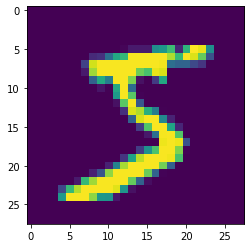

In [14]:
print(training_images.shape)
assert np.allclose(np.sum(training_images, axis=1), 1.0)

fig, axis = plt.subplots()
axis.imshow(np.reshape(training_images[0], (28, 28)))

### Parameters

In [15]:
DT = 0.1
INPUT_SCALE = 80.0
NUM_PN = 784
PRESENT_TIME_MS = 20.0

# Standard LIF neurons parameters
LIF_PARAMS = {
    "C": 0.2,
    "TauM": 20.0,
    "Vrest": -60.0,
    "Vreset": -60.0,
    "Vthresh": -50.0,
    "Ioffset": 0.0,
    "TauRefrac": 2.0}

# We only want PNs to spike once
PN_PARAMS = copy(LIF_PARAMS)
PN_PARAMS["TauRefrac"] = 100.0


### Custom models

In [16]:
# Current source model, allowing current to be injected into neuron from variable
cs_model = genn_model.create_custom_current_source_class(
    "cs_model",
    var_name_types=[("magnitude", "scalar")],
    injection_code="$(injectCurrent, $(magnitude));")

### Model definition

In [17]:
# Create model
model = genn_model.GeNNModel("float", "mnist_mb_first_layer")
model.dT = DT
model._model.set_seed(1337)

# Create neuron populations
lif_init = {"V": PN_PARAMS["Vreset"], "RefracTime": 0.0}
pn = model.add_neuron_population("pn", NUM_PN, "LIF", PN_PARAMS, lif_init)

# Turn on spike recording
pn.spike_recording_enabled = True

# Create current sources to deliver input to network
pn_input = model.add_current_source("pn_input", cs_model, pn , {}, {"magnitude": 0.0})

### Build model

In [18]:
# Concert present time into timesteps
present_timesteps = int(round(PRESENT_TIME_MS / DT))

# Build model and load it
model.build()
model.load(num_recording_timesteps=present_timesteps)

### Simulation

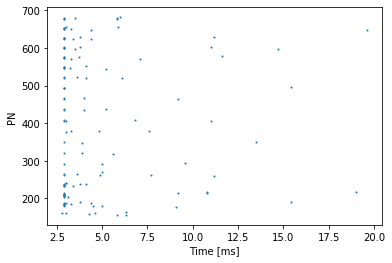

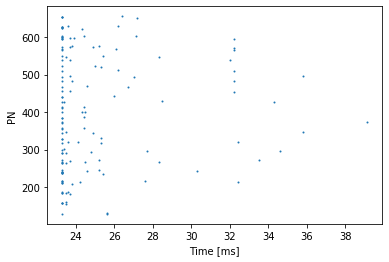

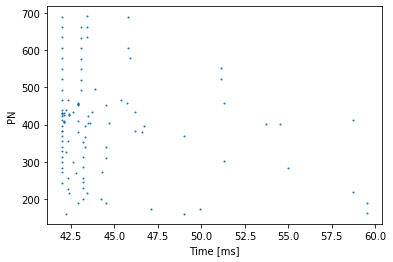

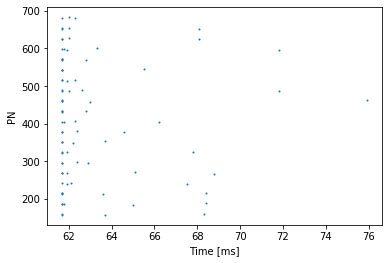

In [19]:
def reset_neuron(pop, var_init):
    # Reset variables
    for var_name, var_val in iteritems(var_init):
        pop.vars[var_name].view[:] = var_val
    
    # Push the state to GPU
    pop.push_state_to_device()
    
for s in range(4):
    # Set training image
    pn_input.vars["magnitude"].view[:] = training_images[s] * INPUT_SCALE
    pn_input.push_var_to_device("magnitude")

    # Simulate timesteps
    for i in range(present_timesteps):
        model.step_time()

    # Reset neuron state for next stimuli
    reset_neuron(pn, lif_init)

    # Download spikes from GPU
    model.pull_recording_buffers_from_device();

    # Plot PN spikes
    fig, axis = plt.subplots()
    pn_spike_times, pn_spike_ids = pn.spike_recording_data
    axis.scatter(pn_spike_times, pn_spike_ids, s=1)
    axis.set_xlabel("Time [ms]")
    axis.set_ylabel("PN")
plt.show()